# Complete pipeline for METLIN-CCS with step-by-step instructions

In [1]:
from SigmaCCS2.ModelPrediction import *
import pandas as pd

## Preprocessing raw data files

### Load the raw data file

In [2]:
ifilepath = './data/METLIN_IMS_all plot CV %3C2% _dimers_rmTM .csv'

### Focus on the three most common adduct types

In [3]:
df = pd.read_csv(ifilepath)
# Rename columns
df = df.rename(columns={'smiles': 'SMILES', 'CCS_AVG': 'True CCS'})
# Replace Adduct types
df['Adduct'] = df['Adduct'].replace({'[M+H]': '[M+H]+', '[M-H]': '[M-H]-', '[M+Na]': '[M+Na]+'})
# Focus on the three most common adduct types
adduct_types = ['[M+H]+', '[M-H]-', '[M+Na]+']
df = df[df['Adduct'].isin(adduct_types)]
print(f"After filtering, there are {len(df)} entries in the dataset.")
df.head(2)

After filtering, there are 61863 entries in the dataset.


,Molecule Name,Molecular Formula,METLIN ID,Precursor Adduct,CCS1,CCS2,CCS3,True CCS,% CV,m/z,...,m/z.1,Dimer,Dimer.1,dimer line,CCS,m/z.2,pubChem,inchi,SMILES,InChIKEY
0,"({[(2,4,6-trimethylphenyl)carbamoyl]methyl}car...",C25H37N3O5,1133361.0,460.2806[M+H],214.67,214.67,214.29,214.54,0.102262,460.2806,...,460.2806,245.447538,Monomer,NaN,135.0,50.0,16384698,InChI=1S/C25H37N3O5/c1-16-11-17(2)22(18(3)12-1...,O=C(COC(=O)C1(CCCC1)CC(=O)NC(C)(C)C)NCC(=O)Nc1...,FEGOCYXICMRAQQ-UHFFFAOYSA-N
1,({[(2-chlorophenyl)carbamoyl]methyl}(methyl)ca...,C24H21ClN2O5,1206876.0,453.1212[M+H],222.35,223.11,222.54,222.67,0.177625,453.1212,...,453.1212,243.520227,Monomer,NaN,310.0,700.0,16292254,InChI=1S/C24H21ClN2O5/c1-27(14-22(29)26-21-5-3...,O=C(Nc1ccccc1Cl)CN(C(=O)COC(=O)c1ccc(cc1)c1ccc...,XZVSMEAQRVNQGK-UHFFFAOYSA-N


### Remove dimers

In [4]:
removed = (df['Dimer.1'] == 'Dimer').sum()
total_before = len(df)
df = df[df['Dimer.1'] != 'Dimer']
total_after = len(df)
print(f"The {removed} entries are removed, and {total_after} entries are retained")

The 3822 entries are removed, and 58041 entries are retained


### Remove entries with disconnected structures (indicated by a "." in its SMILES string)

In [5]:
removed_smiles = (df['SMILES'].str.contains('\\.', regex=True, na=False)).sum()
df = df[~df['SMILES'].str.contains('\\.', regex=True, na=False)]
print(f"Remove {removed_smiles} entries with disconnected structures in SMILES. Remaining entries: {len(df)}.")

Remove 1 entries with disconnected structures in SMILES. Remaining entries: 58040.


### Remove structures unprocessable by RDKit

In [6]:
processable_mask = df['SMILES'].apply(lambda s: Chem.MolFromSmiles(s) is not None)
removed_rdkit = (~processable_mask).sum()
df = df[processable_mask]
print(f"Removed {removed_rdkit} entries unprocessable by RDKit. Remaining entries: {len(df)}.")

[16:09:54] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:09:55] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:09:55] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[16:09:57] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[16:09:57] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
[16:09:58] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16
[16:09:59] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 14 15 16


Removed 7 entries unprocessable by RDKit. Remaining entries: 58033.


### deduplication against the SigmaCCS2 training set

In [7]:
from rdkit.Chem import inchi
# Obtain InChIKey from SMILES
def smiles_to_inchikey(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    try:
        return inchi.MolToInchiKey(mol)
    except Exception:
        return None

train_df = pd.read_csv('./data/TrainingSet.csv')
train_df['InChIKey'] = train_df['SMILES'].apply(smiles_to_inchikey)
train_keys = set(zip(train_df['InChIKey'], train_df['Adduct']))

# Retain entries not present in the training set.
mask = ~df.apply(lambda row: (row['InChIKEY'], row['Adduct']) in train_keys, axis=1)
dedup_df = df[mask]
removed_df = df[~mask]
# Save the deduplicated entries
ifilepath = './data/METLIN-CCS dataset.csv'
dedup_df.to_csv(ifilepath, index=False)
print(f"Following deduplication against the training set, {len(removed_df)} entries were removed, resulting in a final dataset of {len(dedup_df)} entries.")
dedup_df.head(2)

Following deduplication against the training set, 9 entries were removed, resulting in a final dataset of 58024 entries.


,Molecule Name,Molecular Formula,METLIN ID,Precursor Adduct,CCS1,CCS2,CCS3,True CCS,% CV,m/z,...,m/z.1,Dimer,Dimer.1,dimer line,CCS,m/z.2,pubChem,inchi,SMILES,InChIKEY
0,"({[(2,4,6-trimethylphenyl)carbamoyl]methyl}car...",C25H37N3O5,1133361.0,460.2806[M+H],214.67,214.67,214.29,214.54,0.102262,460.2806,...,460.2806,245.447538,Monomer,NaN,135.0,50.0,16384698,InChI=1S/C25H37N3O5/c1-16-11-17(2)22(18(3)12-1...,O=C(COC(=O)C1(CCCC1)CC(=O)NC(C)(C)C)NCC(=O)Nc1...,FEGOCYXICMRAQQ-UHFFFAOYSA-N
1,({[(2-chlorophenyl)carbamoyl]methyl}(methyl)ca...,C24H21ClN2O5,1206876.0,453.1212[M+H],222.35,223.11,222.54,222.67,0.177625,453.1212,...,453.1212,243.520227,Monomer,NaN,310.0,700.0,16292254,InChI=1S/C24H21ClN2O5/c1-27(14-22(29)26-21-5-3...,O=C(Nc1ccccc1Cl)CN(C(=O)COC(=O)c1ccc(cc1)c1ccc...,XZVSMEAQRVNQGK-UHFFFAOYSA-N


## Running predictions, and generating final comparative performance metrics

### Load the SigmaCCS2 model

In [8]:
mfilepath = './model/model.pt'

### Path to save the predicted CCS values

In [9]:
ofilepath = './data/METLIN-CCS dataset-Prediction.csv'

### Use SigmaCCS2 to predict CCS values and generate performance metrics

In [10]:
true_ccs, pred_ccs = SigmaCCS2_predict(ifilepath, mfilepath, ofilepath)

## Read data :  58024
## All Atoms :  ['As', 'Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'Se']
## All Adduct :  ['[M+H]+', '[M+Na]+', '[M-H]-']


100%|████████████████████████████████████████████████████████████████████████████| 58024/58024 [56:44<00:00, 17.04it/s]


## Molecular graph & Line graph & Adduct dataset completed


100%|████████████████████████████████████████████████████████████████████████████| 58024/58024 [11:42<00:00, 82.64it/s]


## CCS predicted completed
R2 Score : 0.8130052414239131
Mean Relative Error : 2.842713515767169 %
Median Relative Error : 2.3623828031497602 %
Mean Absolute Error : 5.523691678727625
Median Absolute Error : 4.499153137207031
Root Mean Squared Error : 7.107051653231788


## Scatter plot of the experimental vs. predicted CCS values

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import *
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
plt.rc('font', family='Times New Roman')
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['mathtext.rm'] = 'Times New Roman'

In [12]:
metrics5 = metrics(true_ccs, pred_ccs)
x_Dt = np.array(pred_ccs).reshape([len(pred_ccs),1]) ################预测值
y_Dt = np.array(true_ccs)

R2 Score : 0.8130052414239131
Mean Relative Error : 2.842713515767169 %
Median Relative Error : 2.3623828031497602 %
Mean Absolute Error : 5.523691678727625
Median Absolute Error : 4.499153137207031
Root Mean Squared Error : 7.107051653231788


Text(115.4800033569336, 213.75509643554688, 'RMSE = 7.11Å$^{2}$')

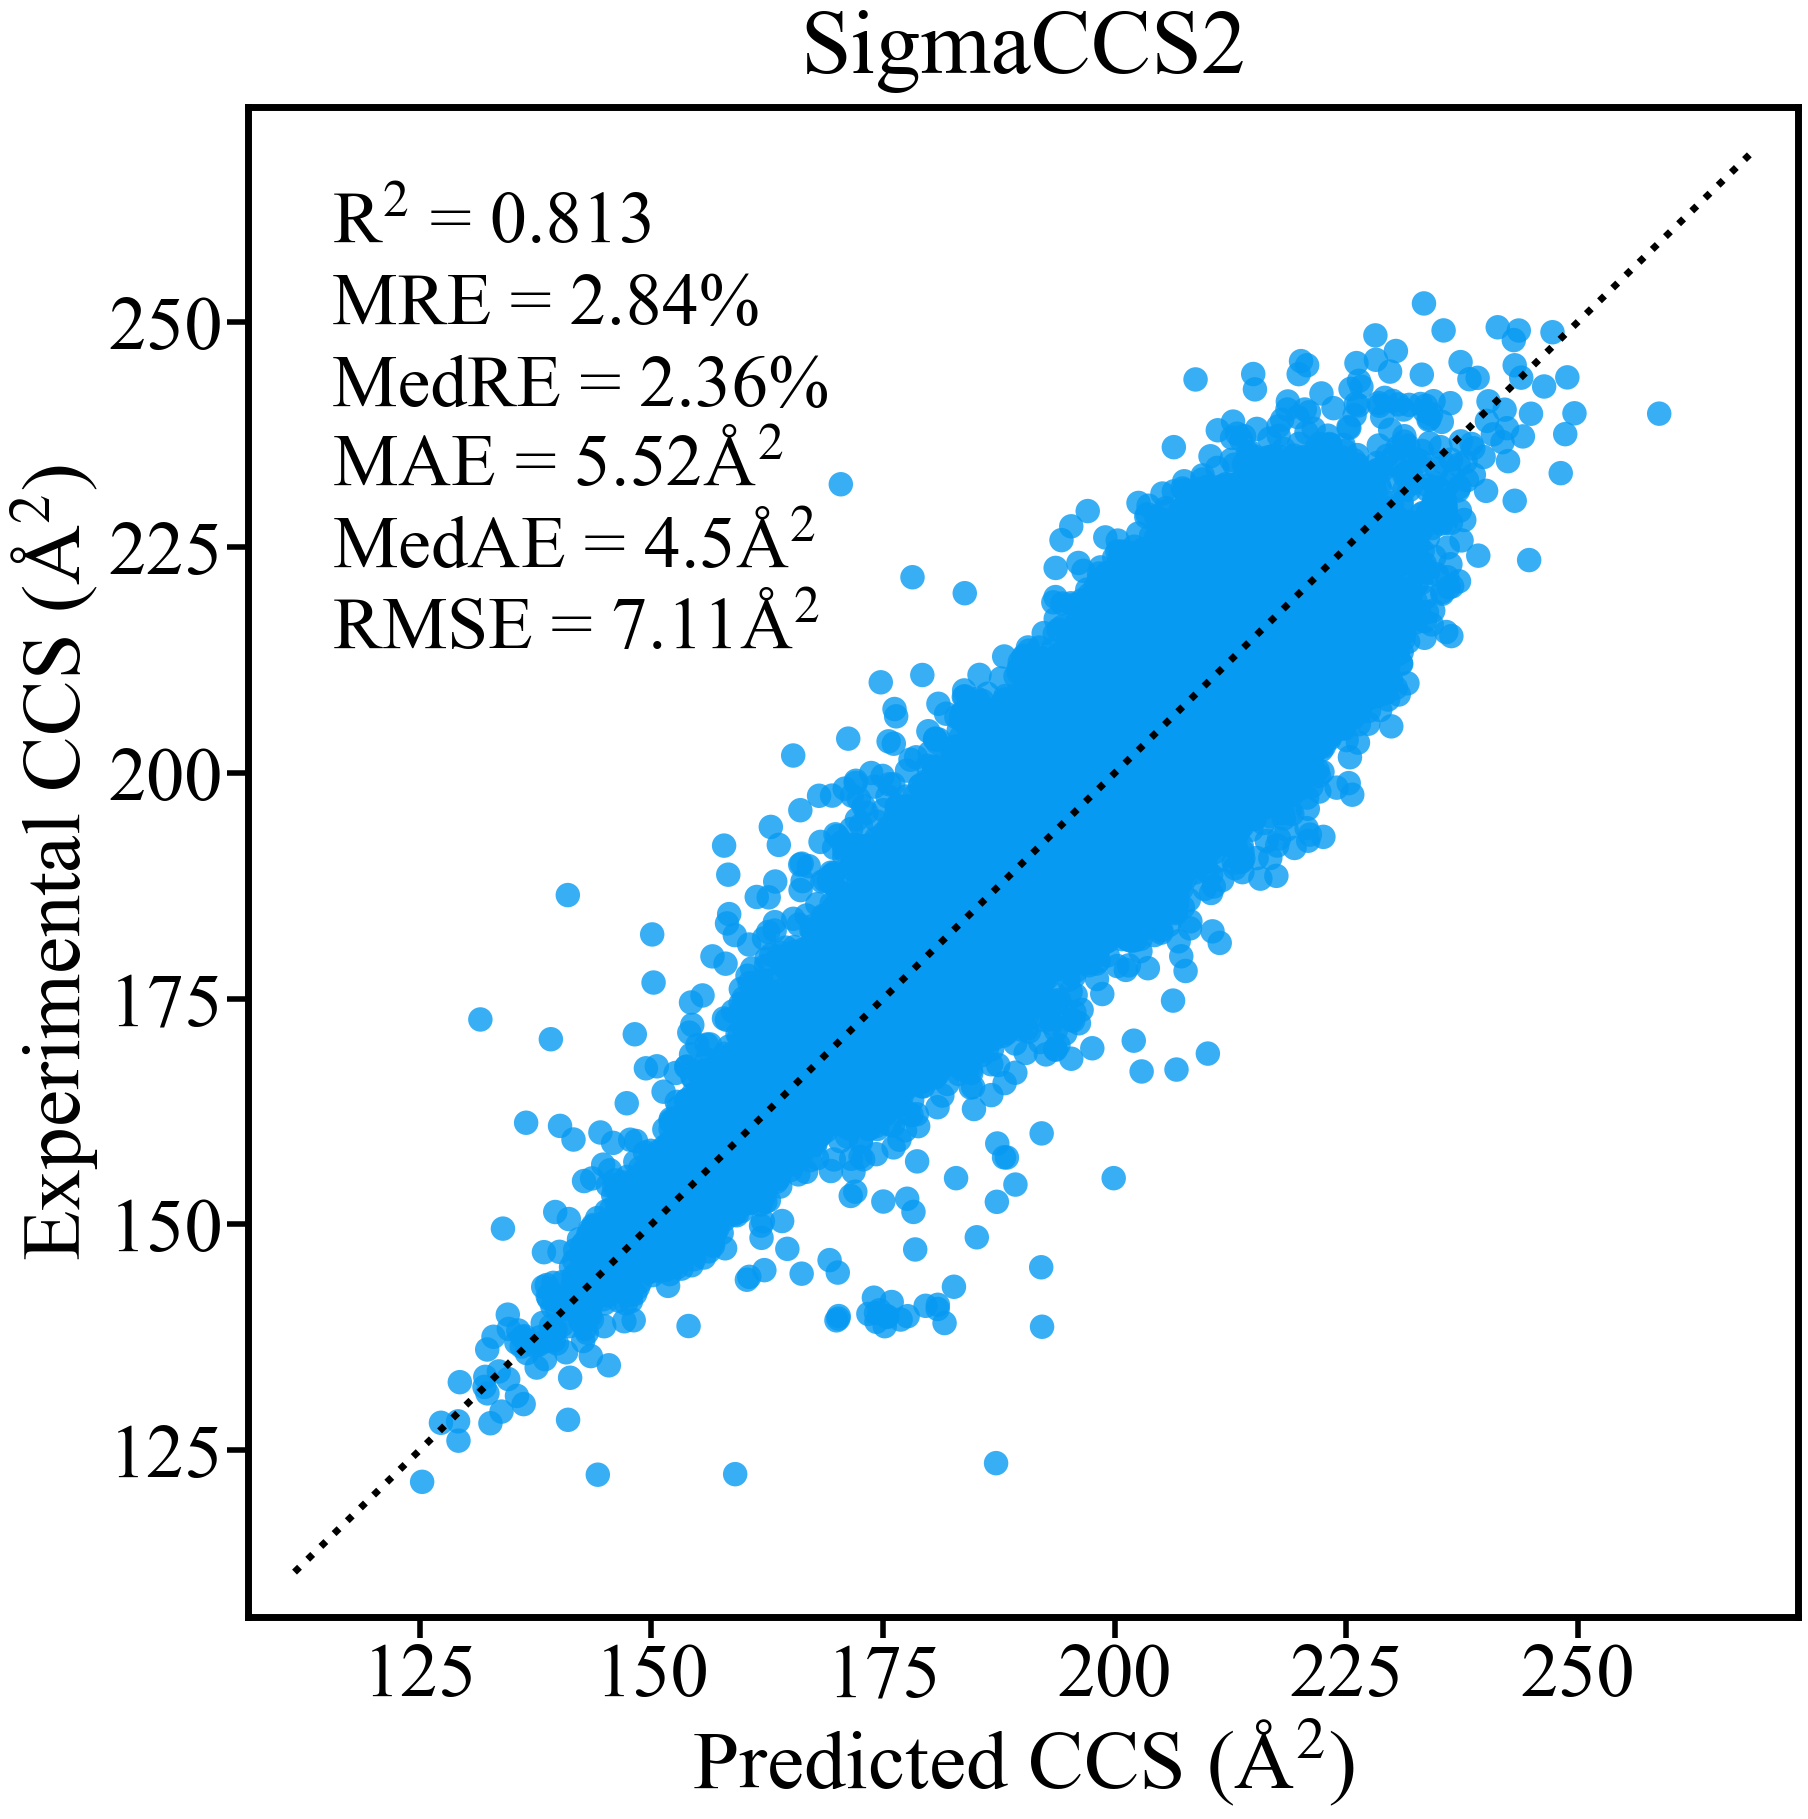

In [13]:
xmin = min(x_Dt.min(), y_Dt.min())
xmax = max(x_Dt.max(), y_Dt.max())
X = np.arange(xmin - 10, xmax + 10).reshape([-1,1])
fig = plt.figure(figsize=(20, 20),facecolor="w",dpi=100)
plt.xlim((xmin - 15, xmax + 15))
plt.ylim((xmin - 15, xmax + 15))

l1 = plt.plot(X, 
              X, 
              color = 'k',
              linestyle = ':', 
              linewidth = 5, 
              alpha = 1,
              label='ref line')

l2_1t = plt.scatter(x_Dt, 
                   y_Dt,
                   alpha=0.8,
                   marker = 'o',
                   s = 310,
                   c = '#069AF3',
                   edgecolors='none')

plt.title('SigmaCCS2', fontsize=65, pad=25)
plt.xlabel('Predicted CCS (Å$^{2}$)',fontsize=60)
plt.ylabel('Experimental CCS (Å$^{2}$)',fontsize=60)
ax1=plt.gca()
ax1.yaxis.set_major_locator(MultipleLocator(25))
ax1.xaxis.set_major_locator(MultipleLocator(25)) 
ax1.spines['top'].set_linestyle("-")
ax1.spines['bottom'].set_linestyle("-")
ax1.spines['right'].set_linestyle("-")
ax1.spines['left'].set_linestyle("-")
ax1.spines['right'].set_linewidth('5')
ax1.spines['top'].set_linewidth('5')
ax1.spines['bottom'].set_linewidth('5')
ax1.spines['left'].set_linewidth('5')
plt.tick_params(labelsize=55,width=4,length=15)

ymin = xmin
ymax = xmax

offset_x = -6 
offset_y = 9 

plt.annotate('R$^2$ = '+str(round(metrics5[0],3)), xy=(xmin + offset_x, ymax - offset_y*0), fontsize=53, color='black')
plt.annotate('MRE = '+str(round(metrics5[1],2))+'%', xy=(xmin + offset_x, ymax - offset_y*1), fontsize=53, color='black')
plt.annotate('MedRE = '+str(round(metrics5[2],2))+'%', xy=(xmin + offset_x, ymax - offset_y*2), fontsize=53, color='black')
plt.annotate('MAE = '+str(round(metrics5[3],2))+'Å$^{2}$', xy=(xmin + offset_x, ymax - offset_y*3), fontsize=53, color='black')
plt.annotate('MedAE = '+str(round(metrics5[4],2))+'Å$^{2}$', xy=(xmin + offset_x, ymax - offset_y*4), fontsize=53, color='black')
plt.annotate('RMSE = '+str(round(metrics5[5],2))+'Å$^{2}$', xy=(xmin + offset_x, ymax - offset_y*5), fontsize=53, color='black')